# Spotify muzikos populiarumo tyrimas

## Šio tyrimo tikslai:

### * Išsiaiškinti, kurie faktoriai labiausiai įtakoja muzikos takelių populiarumą 'Spotify' platformoje;
### * Pabandyti prognozuoti įvairių takelių populiarumą atsižveelgiant į jų parametrus


Turimi muzikinio takelio parametrai:
    * Trukmė(duration);
    * Tonacija (key) išreikšta nuo 0 iki 11, pradedaant C, C#, D, D#, E, F ir t.t.;
    * Dermė (mode), gali būti šviesi 1 arba tamsi 0;
    * Akustiškumas (accousticness) parodo, ar muzika skamba akustiškai, išreikštas skaičiumi tarp 0 ir 1;
    * Tinkamumas šokiams (danceability) išreikštas skaičiumi nuo 0 iki 1;
    * Energetiškumas  (energy) išreikštas skaičiumi nuo 0 iki 1;
    * Instrumentiškumas (instrumentalness) parodo ar takelyje yra vokalo. Kuo reikšmė artesnė 1, tuo didsnė tikimybė, kad takelyje neskamba žmogaus balsas. Reikšmės aukštesnės nei 0.5 dažniausiai reiškia, kad garso takelis yra instrumentinis. 
    * Gyvumas (liveness) parodo, ar takelis buvo įrašytas studijoje, ar gyvo koncerto metu. Kuo didesnė reikšmė, tuo daugiau šansų, kad daina įrašyta koncerto metu. Visi takeliai turintys liveness >= 0.8 įrašyti koncerto metu.
    * Garsas (loudness) varijuoja tarp -60 ir 0. Reprezentuoja takelio garsumą.
    * Kalbumas (speechiness) nurodo kaip dažnai garso takelyje girdime žodžius. Reiškmės virš 0.66 nurodo, kad klausome turbūt net nebe muzikinio įrašo, tačiau pašnekovo, pokalbių laidos. Reikšmės tarp 0.33 ir 0.66 nurodo, kad takelyje skamba muzika, tačiau ji turi žodžius, o reikšmės žemesnės nei 0.33 nurodo, kad takelis yra instrumentinis, tai yra, daina kurios klausome paprasčiausiai neturi žodžių.
    * Nuotaika (valence) nurodoma skaičiumi nuo 0 iki 1, kup reikšmė didesnė, tuo takelis linksmesnis ir pozityvesnis, jei reikšmė žema - takelis niūrus, galbūt net piktas. 
    * Tempas (tempo) tai takelio BPM (Beats per minute), arba takelio ritmo greitis. 
    * Populiarumas (popularity) išreikštas skaičiais nuo 0 iki 100, priklauso nuo perklausų skaičiaus.

# Turimų duomenų analizė

In [151]:
import numpy as np  # Importuojamos reikiamos bibliotekos
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

In [152]:
df = pd.read_csv('data.csv') # Įsikeliami duomenys

In [153]:
df.head() # Galima susidaryti vaizdinį, kaip duomenys atrodo

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [154]:
print(f'Šie duomenys turi {df.shape[0]} eilutes ir {df.shape[1]} stulpelių')

Šie duomenys turi 169909 eilutes ir 19 stulpelių


Kad būtų patogiau sekti duomenis ateityje, stulpeliai pertvarkomi:

In [155]:
df['duration_min'] = df.duration_ms / 60000 # Trukmė milisekundėmis konvertuojama į minutes

In [156]:
df['release_year'] = df.release_date.str.slice(0, 4) # Mums reikalingi tik išledimo metai, 
                                                     # šiuo atveju mėnesiai ir dienos tik apsunkina procesą 
                                                     # ir nėra tiek reikšmingi

In [157]:
# Pertvarkomi stulpeliai
cols = ['artists', 'name', 'popularity', 'duration_min', 'key', 'id', 'release_year', 'mode',
        'acousticness', 'danceability', 'energy',
        'instrumentalness', 'liveness', 'loudness',
        'speechiness', 'tempo',
       'valence', 'year', 'explicit']
df = df[cols]


### Top 20 populiariausių dainų

In [158]:
df[['artists', 'name', 'popularity']].sort_values(by='popularity', ascending = False).head(20)

,artists,name,popularity
87942,['The Weeknd'],Blinding Lights,100
87940,"['DaBaby', 'Roddy Ricch']",ROCKSTAR (feat. Roddy Ricch),99
87949,"['Powfu', 'beabadoobee']",death bed (coffee for your head) (feat. beabad...,97
87941,"['THE SCOTTS', 'Travis Scott', 'Kid Cudi']",THE SCOTTS,96
87852,"['Surf Mesa', 'Emilee']",ily (i love you baby) (feat. Emilee),95
87946,['Drake'],Toosie Slide,95
87840,['Roddy Ricch'],The Box,95
87844,"['BENEE', 'Gus Dapperton']",Supalonely,95
87943,['StaySolidRocky'],Party Girl,94
87951,['6ix9ine'],GOOBA,94


### Tempo vidurkio kitimas pagal metus

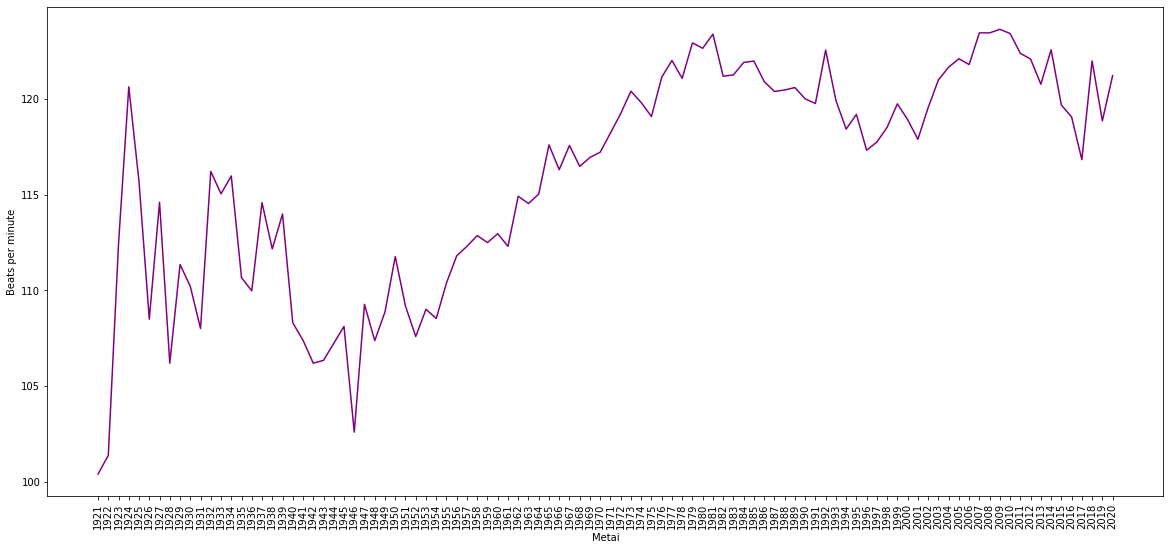

In [159]:
plt.figure(figsize= (20, 9))
tempo_mean = df.groupby('release_year')['tempo'].mean()
plt.plot(tempo_mean, color='purple')
plt.xticks(rotation='90')
plt.xlabel('Metai')
plt.ylabel('Beats per minute')
plt.show()

### Vidutinės takelio trukmės kitimas per metus

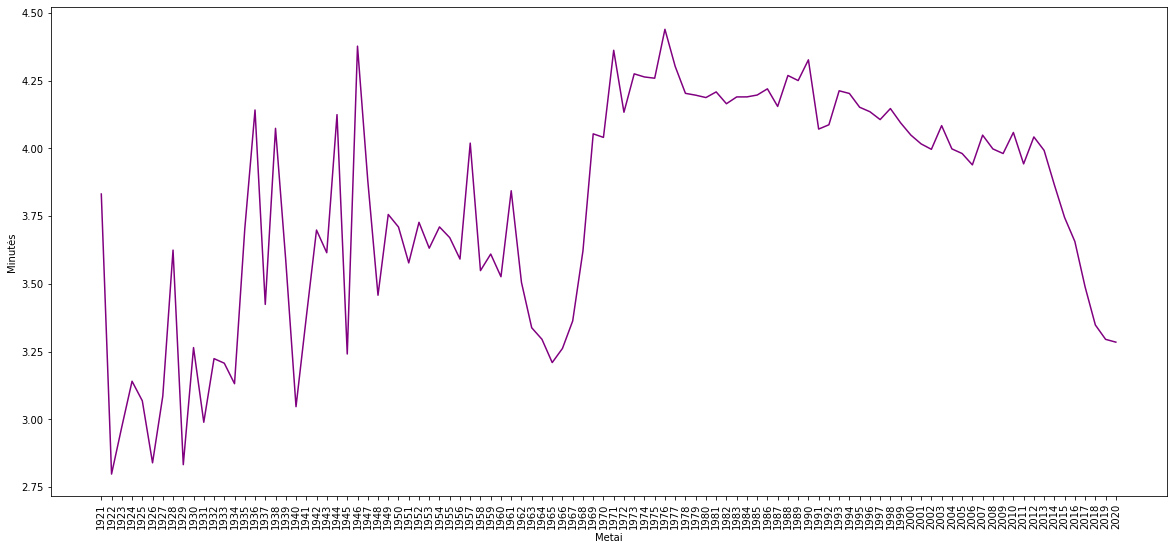

In [160]:
plt.figure(figsize= (20, 9))
duration_mean = df.groupby('release_year')['duration_min'].mean()
plt.plot(duration_mean, color='purple')
plt.xticks(rotation='90')
plt.xlabel('Metai')
plt.ylabel('Minutės')
plt.show()

### Pasiskirstymas pagal populiarumo rodiklį

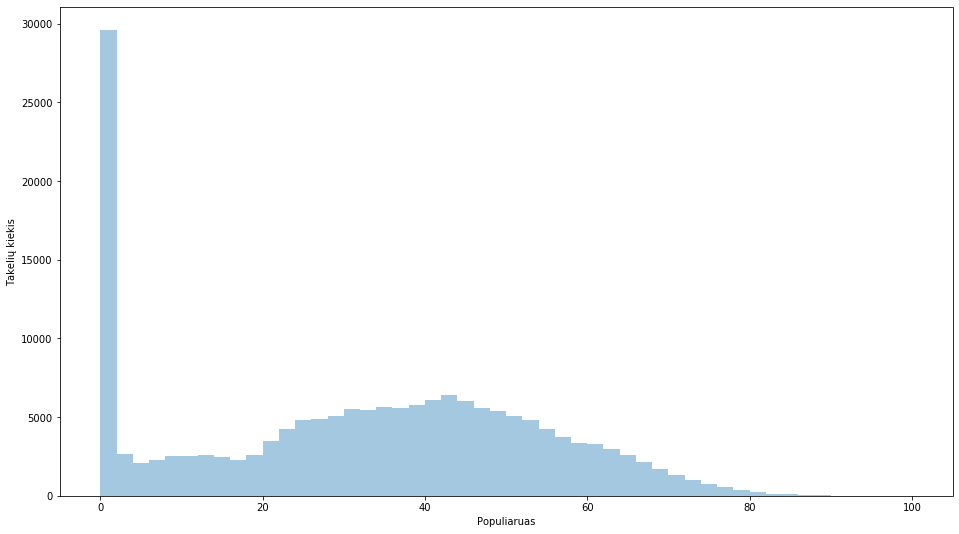

In [161]:
plt.figure(figsize=(16, 9))
sns.distplot(df.popularity, kde=False)
plt.ylabel('Takelių kiekis')
plt.xlabel('Populiaruas')
plt.show()

Šiame grafike galime matyti, kad daugelio takelių populiarumas yra 0, tačiau šioks toks pagyvėjimas yra ties 20 - 60 indeksais. Itin populiarių takelių yra labai mažai, šiame grafike jie net nematyti.

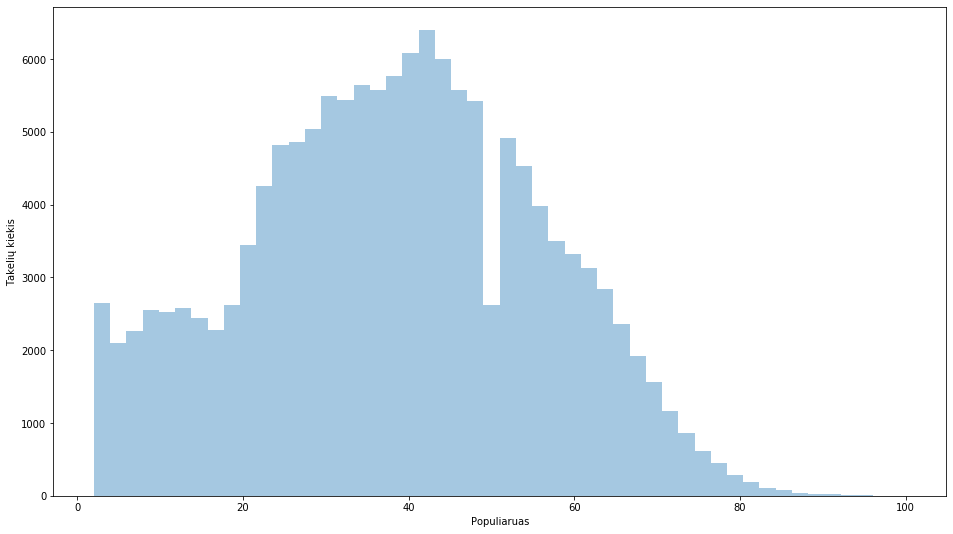

In [162]:
df_pop = df[df['popularity'] > 1]
plt.figure(figsize=(16, 9))
sns.distplot(df_pop.popularity, kde=False)
plt.ylabel('Takelių kiekis')
plt.xlabel('Populiaruas')
plt.show()

### Koreliacija tarp parametrų

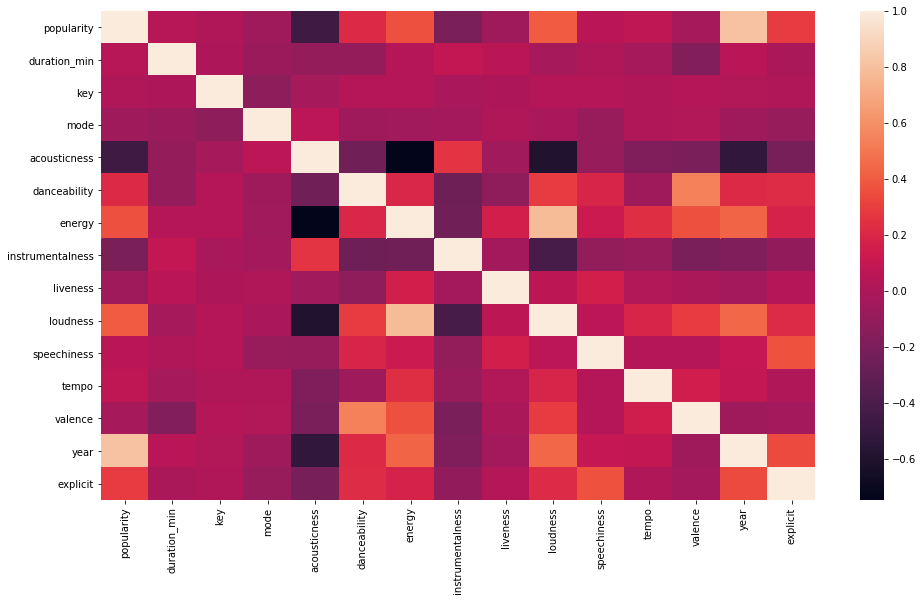

In [163]:
plt.figure(figsize=(16, 9))
sns.heatmap(df_pop.corr())
plt.show()

Šiame koreliacijos žemėlapyje matome, su kuo geriausiai koreliuoja populiarumas, taip pat kurie parametrai koreliuoja tarpusavyje. Labiausiai dominančius galėsime panagrinėti atskirai.

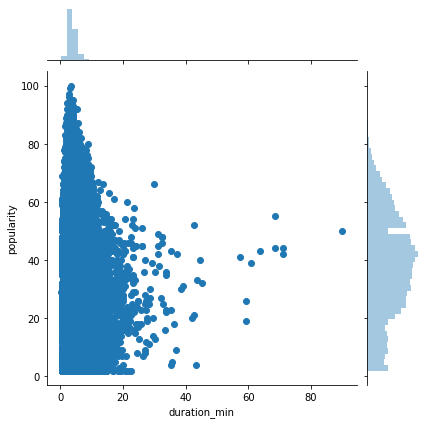

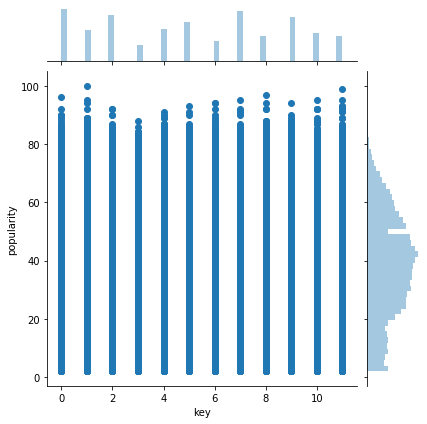

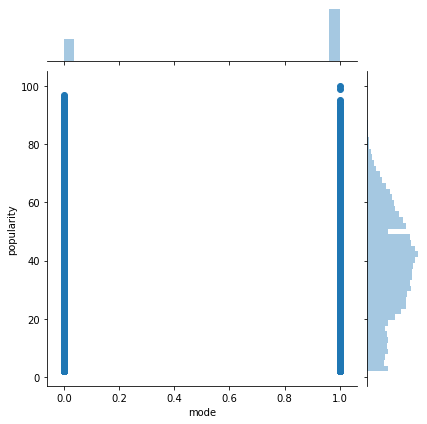

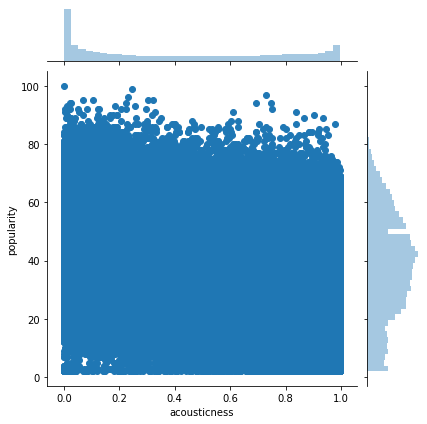

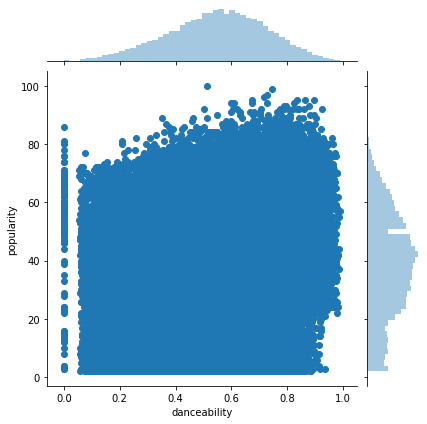

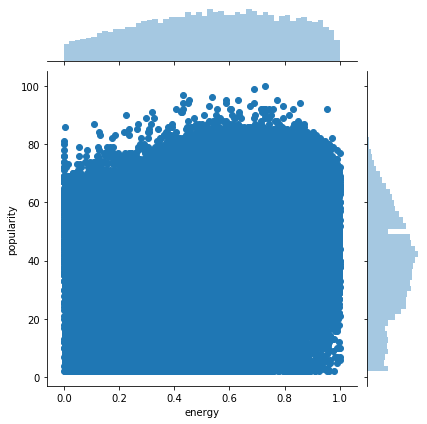

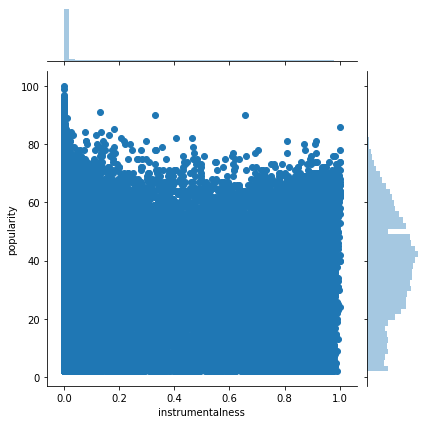

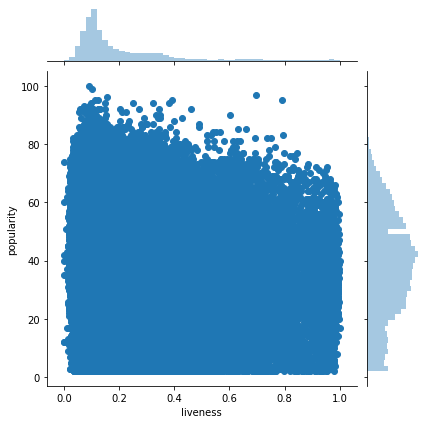

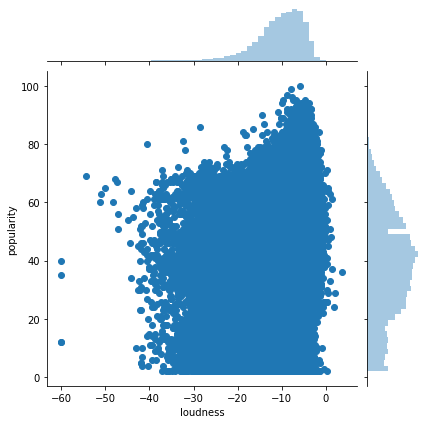

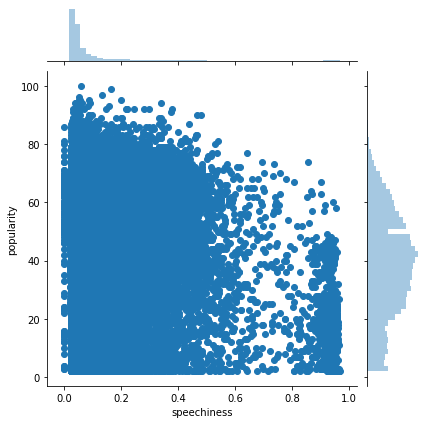

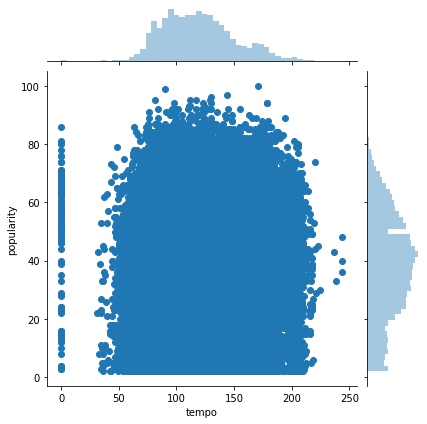

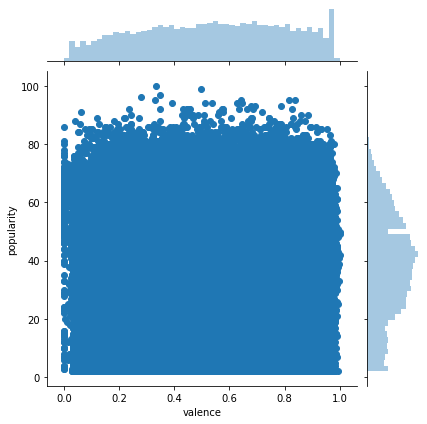

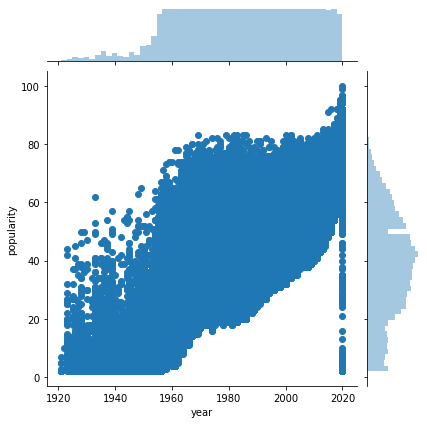

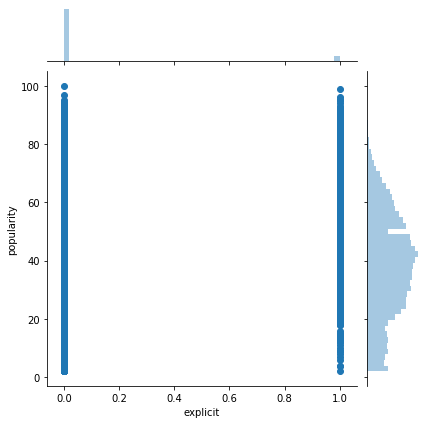

In [164]:

cols1 = ['duration_min', 'key', 'mode',
        'acousticness', 'danceability', 'energy',
        'instrumentalness', 'liveness', 'loudness',
        'speechiness', 'tempo',
       'valence', 'year', 'explicit']
for col in cols1:
    sns.jointplot(x = col, y = 'popularity', data = df_pop)

# Prognozavimas

Šiuo atveju populiarumo prognazavimui naudosiu parametrus kurie:
    1. Koreliuoja su populiarumu;
    2. Kiek įmanoma mažiau koreliuoja tarpusavyje.

In [165]:
from sklearn.model_selection import train_test_split # Importuojamos reikiamos bibliotekos
from sklearn.linear_model import LinearRegression

In [166]:
feature_cols = ['duration_min', 'key', 'mode',
        'acousticness', 'danceability', 'energy',
        'instrumentalness', 'liveness', 'loudness',
        'speechiness', 'tempo',
       'valence', 'year', 'explicit'] # Pasirenkami parametrai 
                                    #pagal kuriuos bus prognozuojamas populiarumas

In [167]:
X = df_pop[feature_cols]
y = df_pop['popularity']

Duomenys padalinami į dalis - 80% bus naudojama modelio treniravimui, su likusiais duomenimis bus išbandomas modelio tikslumas.

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 

In [169]:
print(X_train.shape) # Galima matyti su kokias duomenų kiekias dirbama - treniruojama ir testuojama
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(112238, 14)
(28060, 14)
(112238,)
(28060,)


In [170]:
linear = LinearRegression() 

In [171]:
linear.fit(X_train, y_train) # Duomenys treniravimui patalpinami į modelį

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [172]:
accuracy = linear.score(X_test, y_test) # Modelio tikslumas patikrinamas su duomenimis testavimui
print(accuracy.round(2))

0.67


In [173]:
coeff_df = pd.DataFrame(linear.coef_, X.columns, columns = ['Coefficients'])
coeff_df.sort_values('Coefficients', ascending=False)

,Coefficients
danceability,3.564137
explicit,1.065394
year,0.636612
loudness,0.124002
duration_min,0.040708
tempo,0.002399
key,-0.017260
mode,-0.379907
valence,-0.584452
acousticness,-2.072246


Lentelėje matome kiekvieno parametro koeficientą, arba paprasčiau sakant, numanomą įtaką priklausomui kintamąjam.

In [174]:
predictions = linear.predict(X_test)

Text(0, 0.5, 'prediction')

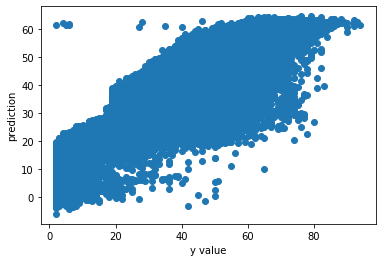

In [175]:
plt.scatter(y_test, predictions)
plt.xlabel("y value")
plt.ylabel("prediction")

Grafike matosi spėtos ir tikros reiškmės

# Išvados

Su populiarumu teigiamai koreliuoja parametrai 'energy', 'danceability', taip pat metai. Tokie parametrai kaip "acousticness' arba 'instumentality' koreliuoja neigiamai. Anot modelio, populiarumo augimui didžiausią  neigiamą įtaką daro 'liveness' ir 'instrumentalness' parametrai, didžiausią teigiamą - 'danceability' parametras.

Pavyko sukurti modelį, kuris nuspėtų muzikinio takelio populiarumą ~ 67% tikslumu. Modelis vadovaujasi parametrais, kurie turi didžiausią koreliaciją su populiarumu, tačiau kiek įmanoma mažiau koreliuoja tarpusayje, taip siekiant sumažinti modelio "overfitting".